# Part 1. Explorartory Data Analysis  (EDA)

## Challenge:
###### Logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Report/illustrate important features of the demand, such as daily cycles. Report any data quality issue.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Read the json file
EDA_df = pd.read_json('logins.json')
EDA_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
#Test if there are any null values and the data types
EDA_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
#There are no Null values. All data in login_time is Datetime64 format

#Let's check the min and max values of this column.
print(np.min(EDA_df.login_time))
print(np.max(EDA_df.login_time))

1970-01-01 20:12:16
1970-04-13 18:57:38


In [5]:
#So the datetime is between January 1 1970 and April 13, 1970

#Aggregate the datetime data by 15min interval
#Transform the dataframe by using datetime as the index
agg_df = EDA_df.set_index('login_time')
agg_df['count'] = 1
agg_df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [6]:
#aggregate by 15min and count the total number of logins
agg = agg_df.resample("15T").agg({'count':'sum'})
agg.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Text(0.5, 1.0, 'Number of Login Every 15min Over Time')

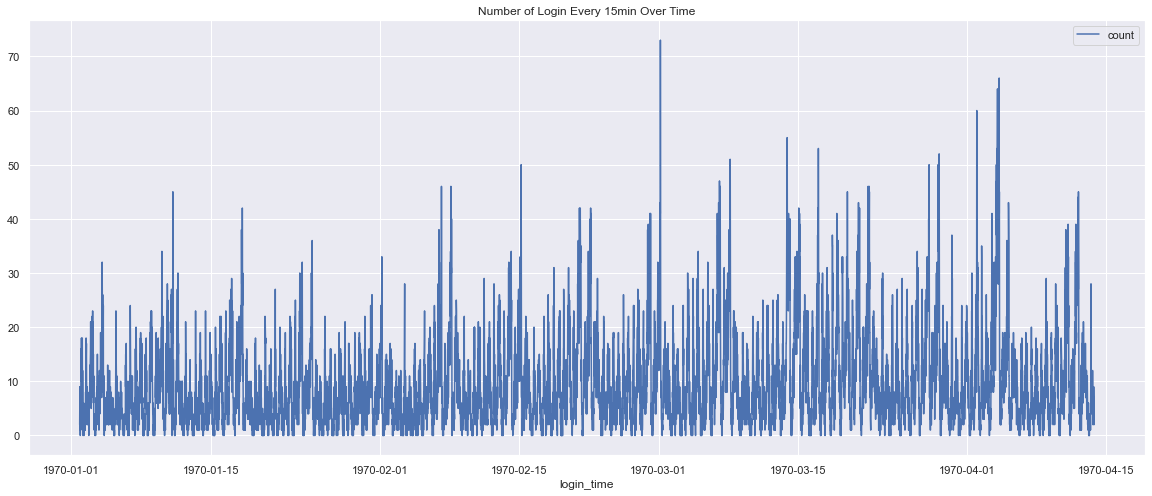

In [7]:
sns.set_theme()
plt.figure(figsize=(20,8))
sns.lineplot(data=agg,color='#9d94ba')
plt.title('Number of Login Every 15min Over Time')

The figure above shows the total number of login every 15min. We can see that there are lots of noises, as login activities might be dependent on the time of the day. For example, the number of login may be higher during the day than in the afternoon. 

We can explore the daily number of login:

Text(0.5, 1.0, 'Number of Login Every 24 hours Over Time')

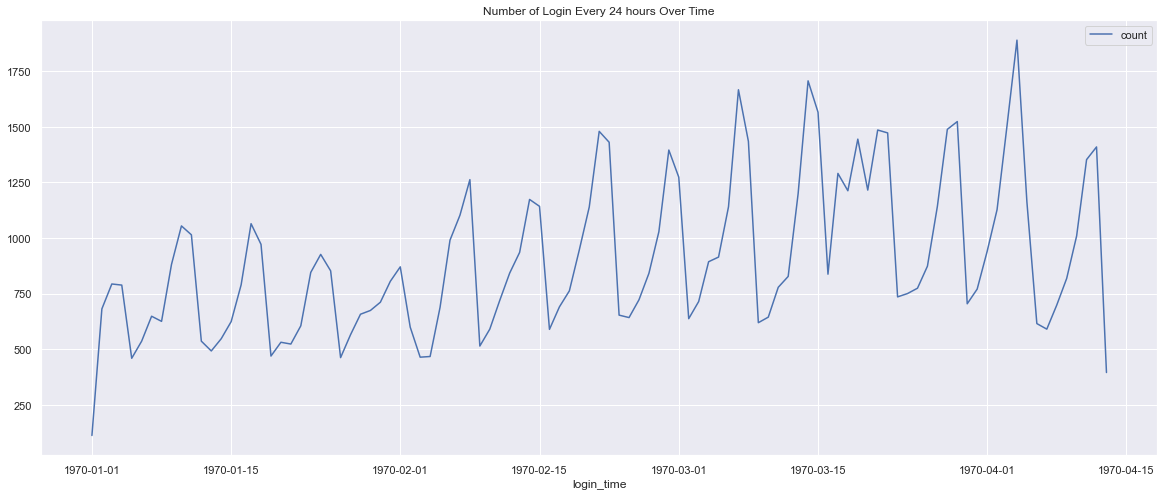

In [8]:
agg_D = agg_df.resample("D").agg({'count':'sum'})
sns.set_theme()
plt.figure(figsize=(20,8))
sns.lineplot(data=agg_D,color='#9d94ba')
plt.title('Number of Login Every 24 hours Over Time')

Most of the noises have been removed by resample the data by day, instead of 15min. As we can see, there is a obvious pattern of peak every certain days, which might be the week. Overall, from January to April, the number of login increased.

To explore more about the patterns of timeseries data, we can also leverage libraries, e.g. StatsModels. The seasonal decomposition model will decompose the data based on it's pattern and remove the disruptive noises.

In [9]:
#Import statsmodels API
import statsmodels.api as sm
#Set the period. Since we have seen a possible trend of regular change in weeks, we can use 7 days
decompfreq = 4*24*7
#Assign the results
results = sm.tsa.seasonal_decompose(agg, model='additive',period=decompfreq)

<AxesSubplot:xlabel='login_time'>

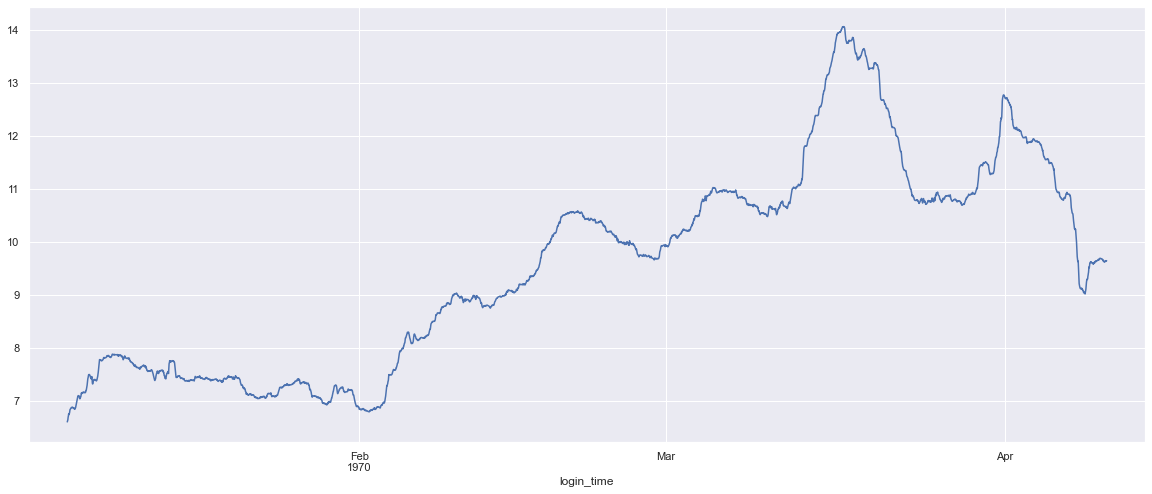

In [10]:
#Plot the overall trend of the data
plt.figure(figsize=(20,8))
results.trend.plot()

The login does have a increasing trend from January to April in 1970, although we saw some decrease at the end of March and April.

<AxesSubplot:xlabel='login_time'>

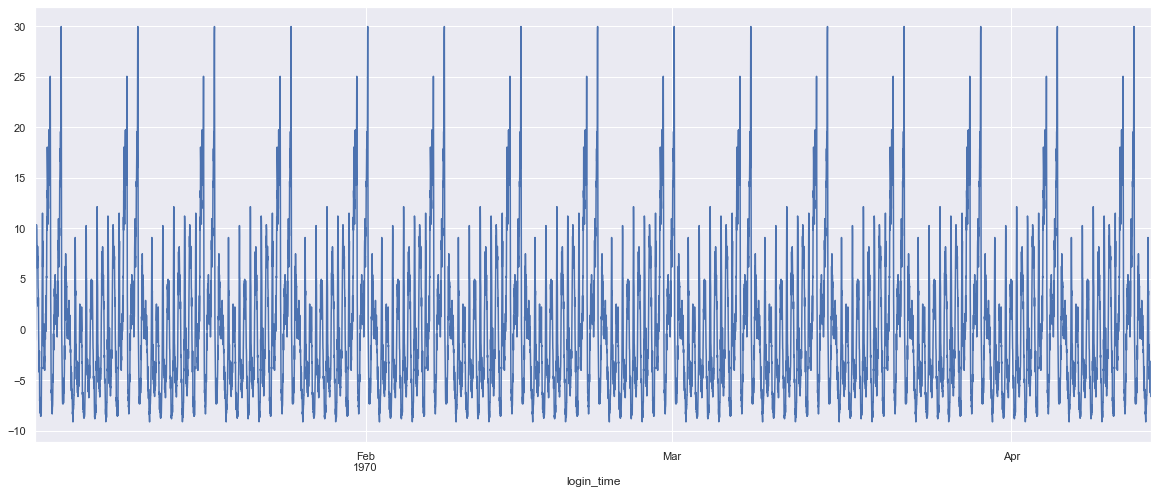

In [11]:
#Plot the Seasonality
plt.figure(figsize=(20,8))
results.seasonal.plot()

The above figure shows the seasonality of the data. We can definitely see a trend and it fluctuate between -10 to 30. Each cycle is about a week, and each month have 4 cycles.

<AxesSubplot:xlabel='login_time'>

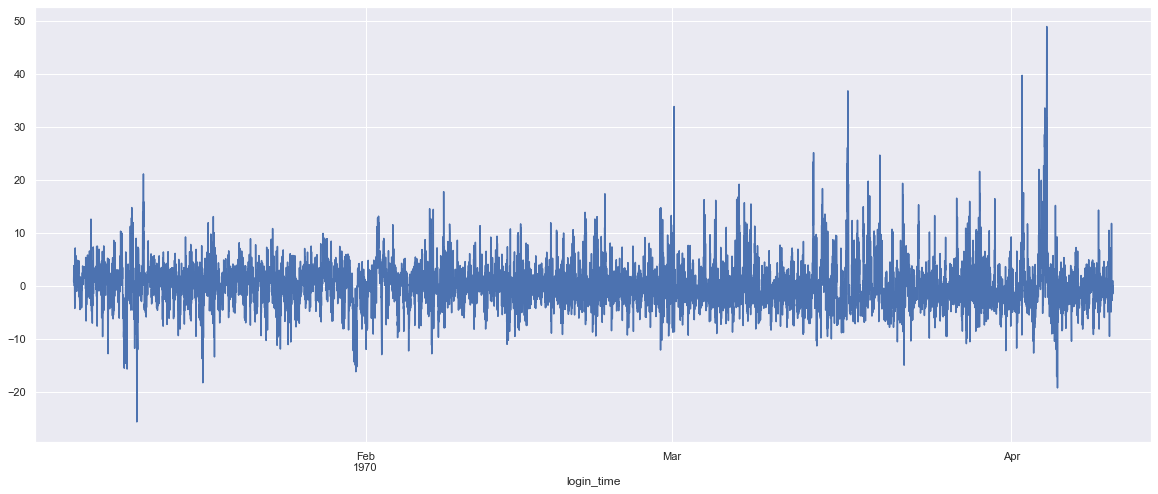

In [12]:
#Plot the randomness of the data
plt.figure(figsize=(20,8))
results.resid.plot()

The above figure shows the random noise of the data left after removing the seasonalality and trend.

# Part 2. Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.


1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Answer:

The key measure of success of this experiment can be the increasing number of tolls that the partner driver paid. There are a few reasons to choose this measure:

1. The toll data of drvier partners is easy to collect and has been collected previously. Previous data can be used as control group, while new data collected can be used as variable group.

2. Drivers will definitely be tolled if they serve the other city, which can be comparable if there are any differences

3. The toll data will not only include the count of passing each day, but also the time of the toll. Peak hour of passing bridges can also be interpreted.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    
    
    a) how you will implement the experiment

Answer:

We can follow the following steps to implement the experiment

1. Fomulate a hypotehsis and set goals of the experiment test. Here, we can create a null-hypothesis and an alternative hypothesis.
2. Collect toll data of partner drivers of 1 week, including weekdays and weekends
3. Implement the toll reimbursement, and collect the toll data of partner drivers of 1 week, including weekdays and weekends
4. Contuct hypothesis analysis, including calculating average, min, max of the number of crossing the bridges. Calculate the p values to check if the difference of these numbers are statistically significant.

    b) what statistical test(s) you will conduct to verify the significance of the observation

Answer:

We can conduct hypothesis analysis for the average, minimum, or maximum daily and weekly flow of the bridges before and after implementing the toll reimbursement.

    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Answer:

If the test results are statistically significant, we can recommend the city operations team to implement the reimbursement further. We can keep collecting data and monitor if the drives cross more, or if there are seasonal patterns

If the test results are not statistically significatn, we can recommend the city a few alternatives:

1) investigate the reasons of drivers not passing the bridge by completing a survey

2) we can increase the length of the experiment, as some of the drivers may not be informed of the changes

# Part 3. Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.




2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.




Data description
● city: city this user signed up in
● phone: primary device for this user
● signup_date: date of account registration; in the form ‘YYYYMMDD’
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
● avg_rating_by_driver: the rider’s average rating over all of their trips
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
● surge_pct: the percent of trips taken with surge multiplier > 1
● avg_surge: The average surge multiplier over all of this user’s trips
● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
● weekday_pct: the percent of the user’s trips occurring during a weekday


1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

## 1.1 Import Data

In [13]:
#Read the json file
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
#Check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [15]:
#Convert signup_date and last_trip_date to Datetime
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)

## 1.2 Data Cleaning

In [16]:
#avg_rating_of_driver and avg_rating_by_driver has null values
#Fill these null values with median so that they will not cause any issues for models
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [17]:
#Phone types also have null data. 

#Count the number phones
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [18]:
#As iphone is the dominent phone in the users, we will fill the null phone types using iPhone
df['phone'] = df['phone'].fillna('iPhone')
df['phone'].value_counts()

iPhone     34978
Android    15022
Name: phone, dtype: int64

## 1.3 Data Manipulating and Organizing

The main purpose of this section is to prepare the target column.

We will figure out the last day of data collection first

In [19]:
#Find the latest day for the entire last_trip_date
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [20]:
#So, any of the data 30 days before July 1st, 2014 would be inactivate user
#Caculate the 30 days before July 1st, 2014
from datetime import timedelta
last_day = df['last_trip_date'].max() - timedelta(days=30)
print(last_day)

2014-06-01 00:00:00


In [21]:
#Create a new column for the target, the column would be a boolean
df['activate'] = df['last_trip_date'] > last_day
df['activate'].head()

0     True
1    False
2    False
3     True
4    False
Name: activate, dtype: bool

In [22]:
#Create a new dataframe that remove the last_trip_date
dfp = df.drop(columns=['last_trip_date'])
dfp.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activate
0,King's Landing,4,2014-01-25,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,False


In [23]:
#Also, we can transform the signup_date to the time registered
import datetime as dt
dfp['signup_days'] = (df['last_trip_date'].max() - df['signup_date']).dt.days.astype('int16')
dfp = dfp.drop(columns=['signup_date'])
dfp.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activate,signup_days
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,True,157
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,False,153
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,False,176
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,True,172
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,False,155


## 1.4 Exploratory Data Analysis

### 1.4.1 Number of Users in Cities

In [24]:
#Count the number of cities
dfp.city.value_counts().sort_values(ascending=False)

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

Only 3 cities in the dataset and Winterfell has the most users

### 1.4.2 Number of Black Users

In [25]:
#Count the number of black users
dfp.ultimate_black_user.value_counts().sort_values(ascending=False)

False    31146
True     18854
Name: ultimate_black_user, dtype: int64

### 1.4.3 Number of Activate Users

In [26]:
dfp.activate.value_counts().sort_values(ascending=False)

False    31690
True     18310
Name: activate, dtype: int64

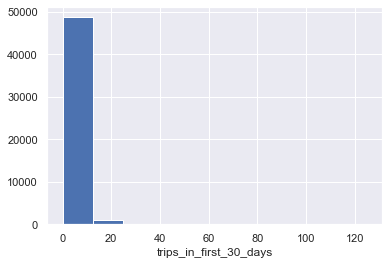

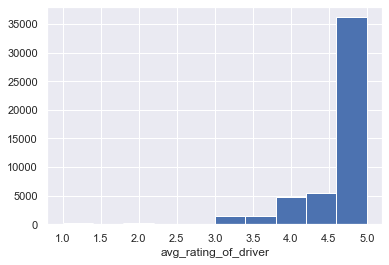

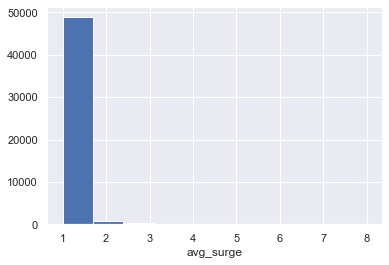

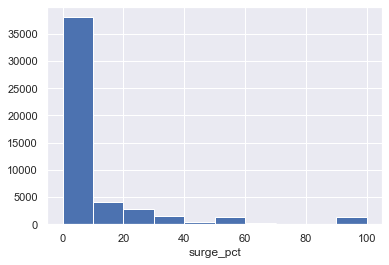

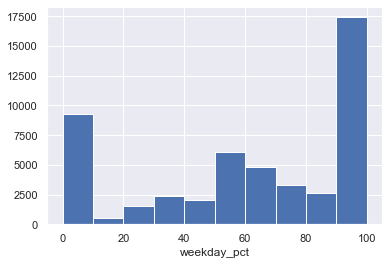

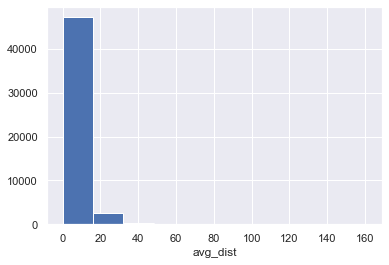

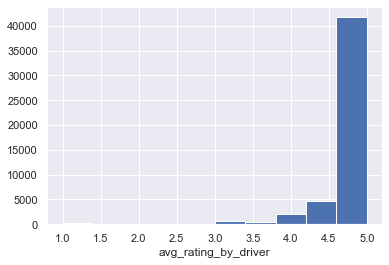

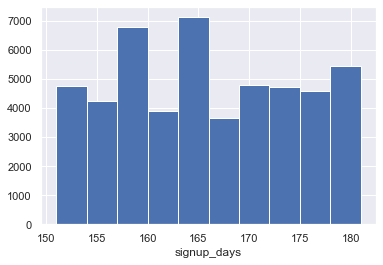

In [27]:
columns = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct',
          'avg_dist','avg_rating_by_driver','signup_days']
for col in dfp[columns].columns:
    plt.hist(dfp[col])
    plt.xlabel(col)
    plt.show()

In [28]:
dfp.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,50000.0,4.650038,0.575601,1.0,4.50,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,50000.0,4.779050,0.445974,1.0,4.70,5.00,5.00,5.00
signup_days,50000.0,165.455320,8.754220,151.0,158.00,165.00,173.00,181.00


### 1.4.4 Relationship with target data

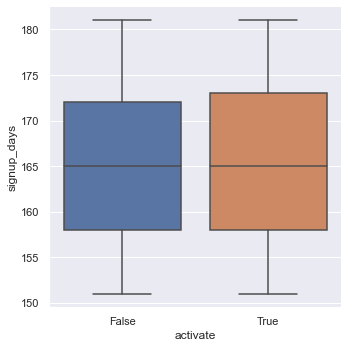

In [29]:
sns.catplot(x='activate', y='signup_days', kind="box", data=dfp)

It seems that there is no relationship between the signup days and whether the user is activate or not. The average signup days is about 165, up to July 1st, 2014.

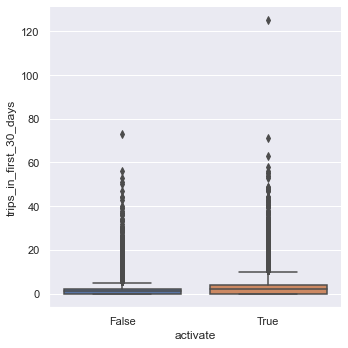

In [30]:
sns.catplot(x='activate', y='trips_in_first_30_days', kind="box", data=dfp)

It seems that the current activate users will have more average trips in the first 30 days after they registered.

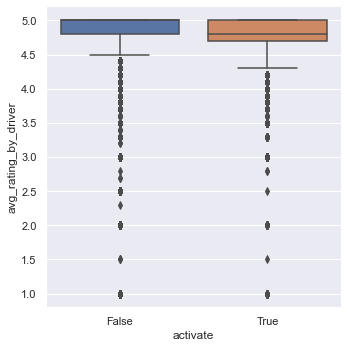

In [31]:
sns.catplot(x='activate', y='avg_rating_by_driver', kind="box", data=dfp)

### 1.4.5 Relationship between Features

<AxesSubplot:>

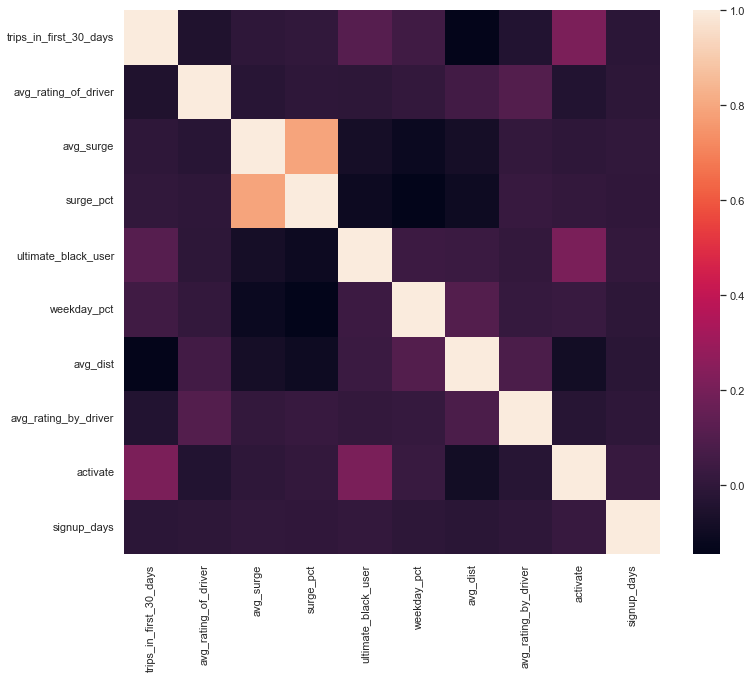

In [32]:
plt.subplots(figsize=(12,10))
sns.heatmap(dfp.corr())

Surge percentage seems to be related to the averge surge rate. This is reasonable because the more it is surged, the greater the average surge rate.

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

## 2.1 Prepare Training and Test Data

In [33]:
#Look at the data first and see if there are any pre-model preparation to do
dfp.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activate,signup_days
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,True,157
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,False,153
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,False,176
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,True,172
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,False,155


Phone and city can be transformed to binary coding.
Boolean data types to be transformed to 0 and 1.

In [34]:
#Transform Boolean to 0 and 1
dfp["ultimate_black_user"] = dfp["ultimate_black_user"].astype(int)
dfp["signup_days"] = dfp["signup_days"].astype(int)
dfp["activate"] = dfp["activate"].astype(int)
dfp.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activate,signup_days
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1,157
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0,153
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,0,176
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1,172
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,0,155


In [35]:
#Get Dummies for categorical columns, including drop the first column
dfp_Xy = pd.get_dummies(dfp
               ,columns = ['city','phone']
               ,drop_first = True
               )
dfp_Xy.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activate,signup_days,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,157,1,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,153,0,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,176,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,172,1,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,155,0,1,0


## 2.2 Modeling

### 2.2.1 Logistic Regression

In [36]:
#Before making a model, we can have a preview of the model features by using logistic regression from statsmodels.api
import statsmodels.api as sm
logit_model=sm.Logit(dfp_Xy.activate,dfp_Xy.drop(columns='activate'))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.547367
         Iterations 6
                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.167     
Dependent Variable:   activate           AIC:                54760.7346
Date:                 2022-08-04 16:19   BIC:                54866.5719
No. Observations:     50000              Log-Likelihood:     -27368.   
Df Model:             11                 LL-Null:            -32845.   
Df Residuals:         49988              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
trips_in_first_30_days  0.1195   0.0035  34.6096 0.0000  0.1128

All features have P value less than 0.05, except the signup_days, which indicate there is no significant relationship between the signup_days to the activation. We can remove the signup-days and test again.

In [37]:
import statsmodels.api as sm
logit_model=sm.Logit(dfp_Xy.activate,dfp_Xy.drop(columns=['activate','signup_days']))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.547396
         Iterations 6
                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.167     
Dependent Variable:   activate           AIC:                54761.5846
Date:                 2022-08-04 16:19   BIC:                54858.6022
No. Observations:     50000              Log-Likelihood:     -27370.   
Df Model:             10                 LL-Null:            -32845.   
Df Residuals:         49989              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
trips_in_first_30_days  0.1193   0.0034  34.5831 0.0000  0.1125

In [38]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(dfp_Xy.drop(columns=['activate','signup_days']), 
                                                    dfp_Xy.activate, test_size=0.3, 
                                                    random_state=47)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35000, 11) (15000, 11) (35000,) (15000,)


In [39]:
#Standarized the data by using the StandardScaler from sklearn. This is to make the numbers in a consistent scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
#Fit the model using sklearn logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [41]:
#Make predictions
y_pred = logreg.predict(X_test_scaled)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_scaled, y_test)))

Accuracy of logistic regression classifier on test set: 0.73


/Users/andygong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


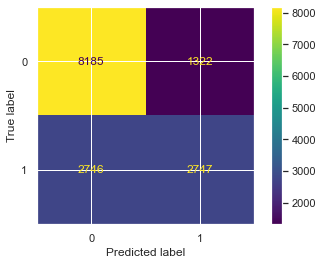

In [42]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg, X_test_scaled, y_test)  
plt.show()

We do see some imbalance in the activate users and non-activate users. Maybe we can try to oversampling the data to make them balanced.


In [46]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['activate'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['activate']==0]))
print("Number of subscription",len(os_data_y[os_data_y['activate']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['activate']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['activate']==1])/len(os_data_X))

length of oversampled data is  44366
Number of no subscription in oversampled data 22183
Number of subscription 22183
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [56]:
scaler = StandardScaler()
scaler.fit(os_data_X)
os_X_train_scaled = scaler.transform(os_data_X)
os_X_test_scaled = scaler.transform(X_test)

In [57]:
from sklearn.utils import column_or_1d
os_data_y = column_or_1d(os_data_y, warn=True)

In [58]:
o_logreg = LogisticRegression()
o_logreg.fit(os_X_train_scaled, os_data_y)

LogisticRegression()

In [59]:
o_y_pred = o_logreg.predict(os_X_test_scaled)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(os_X_test_scaled, y_test)))

Accuracy of logistic regression classifier on test set: 0.70


/Users/andygong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


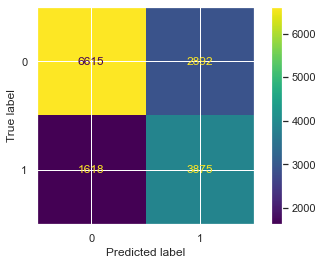

In [60]:
plot_confusion_matrix(o_logreg, os_X_test_scaled, y_test)  
plt.show()

It seems that the oversampling did not make the model better, even worse in making predictions

In [ ]:
#Check feature importance without the over sampling

In [75]:
#Use Recursive Feature Elimination to interpret the most important
#features
from sklearn.feature_selection import RFE
selector = RFE(logreg, n_features_to_select = 1)
selector = selector.fit(X_train_scaled, y_train)
importance_df = pd.DataFrame({'Features':list(X_train.columns),
                             'Ranks':selector.ranking_})
importance_df.sort_values(by='Ranks')

,Features,Ranks
0,trips_in_first_30_days,1
8,city_King's Landing,2
10,phone_iPhone,3
4,ultimate_black_user,4
9,city_Winterfell,5
6,avg_dist,6
1,avg_rating_of_driver,7
7,avg_rating_by_driver,8
3,surge_pct,9
2,avg_surge,10


The feature elimination package indicated that the top three features would be the trips in first 30 days, whether they are a King's Landing customer, or they are a Iphone user. Black users might also be a important feature for retain this customer. 

However, surge percentage, agerage surge, and weekday percentage is the least important features to the retention rate. It indicated that surge doesn't have much impact to the user's intention to take Utimate cars.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

There are a few things to be considered to improve rider retention:

1) Improve users' first 30-day trips. It turns out that the more trips the rider uses in 30 days after registration, the more they are likely to retain long. First impression is always a good indicator.

2) Investigate if there are competitors in Winterfell and Astapor. It seems that King's Landing has more loyaty riders, while other cities have less retention rate. Is it because the market is being shared by other companies? 

3) Investigate the user experiences on Android user. iPhone users may have more loyaty riders. Does it suggest any issues that Android user 